# This notebook contains queries and visualizations for the Chinook Analysis using SQL project

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///chinook.db')

### Query \#1: Lets find the customer that has spent the most on music for each country.

1. Think of a table t1 that lists the total amount spent by each person, along with their country (this one is kind of easy)
2. To select only the top spenders for each country we could simply select MAX(TotalSpent) from t1 and GROUP BY Country.
The problem is that there are countries with 2 people that spent the same top-amount and we want them both in the final result. MAX would only return one of them.
4. Create a table t2 that contains only the max-spender by country
5. Join t1 and t2 and use the clause WHERE t1.TotalSpent = t2.MaxTotalSpent to select only top spenders at the same time you keep more than one in case they exist

In [67]:
q1 = '''
WITH t1 AS 
(
	SELECT c.Country, SUM(i.Total) TotalSpent, c.FirstName, c.LastName, c.CustomerId
	FROM 
		Customer c
		JOIN Invoice i ON c.CustomerId = i.CustomerId
	GROUP BY c.CustomerId
)

SELECT t1.*
FROM t1
JOIN(
	SELECT Country, MAX(TotalSpent) AS MaxTotalSpent, FirstName, LastName, CustomerId
	FROM t1
	GROUP BY Country
)t2
ON t1.Country = t2.Country
WHERE t1.TotalSpent = t2.MaxTotalSpent
ORDER BY TotalSpent DESC, Country
LIMIT 7;
'''

In [68]:
df1 = pd.read_sql(q1, engine)
df1

,Country,TotalSpent,FirstName,LastName,CustomerId
0,Czech Republic,49.62,Helena,Holý,6
1,USA,47.62,Richard,Cunningham,26
2,Chile,46.62,Luis,Rojas,57
3,Hungary,45.62,Ladislav,Kovács,45
4,Ireland,45.62,Hugh,O'Reilly,46
5,Germany,43.62,Fynn,Zimmermann,37
6,Austria,42.62,Astrid,Gruber,7


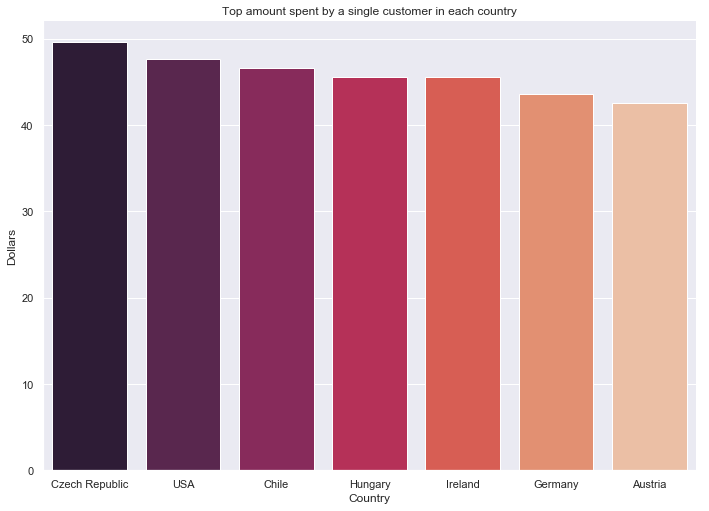

In [69]:
# Lets see the distribution of top-spenders along countries
fig, _ = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.despine()
_ = sns.barplot(x=df1.Country, y=df1.TotalSpent, palette='rocket')
plt.xlabel("Country")
plt.ylabel("Dollars")
plt.title("Top amount spent by a single customer in each country")
plt.show(fig)

### Query \#2: Lets see how many rock songs were purchesed from each country

In [65]:
q2 = '''
SELECT i.BillingCountry Country, COUNT(*) RockSongsPurchased
FROM Invoice i
	JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId
	JOIN Track t ON il.TrackId = t.TrackId
	JOIN Genre g ON t.GenreId = g.Genreid
WHERE g.Name = 'Rock'
GROUP BY BillingCountry
ORDER BY RockSongsPurchased DESC, BillingCountry
LIMIT 7;
'''

In [72]:
df2 = pd.read_sql(q2, engine)
df2

,Country,RockSongsPurchased
0,USA,157
1,Canada,107
2,Brazil,81
3,France,65
4,Germany,62
5,United Kingdom,37
6,Portugal,31


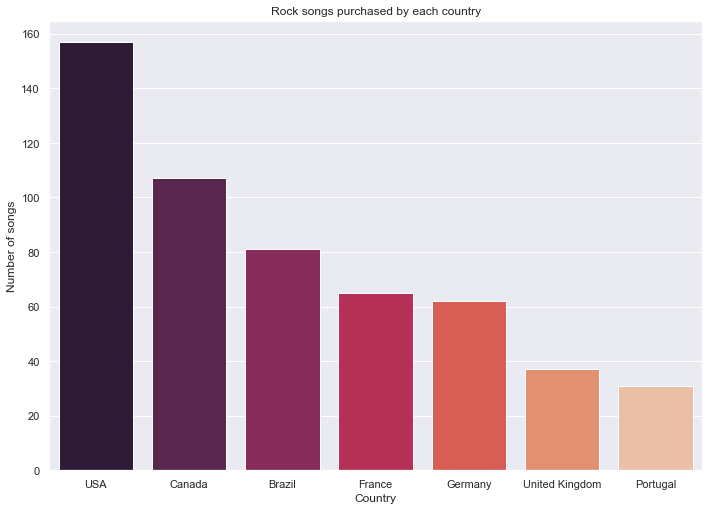

In [75]:
fig, _ = plt.subplots()
fig.set_size_inches(11.7, 8.27)
_ = sns.barplot(x=df2.Country, y=df2.RockSongsPurchased, palette='rocket')
plt.xlabel("Country")
plt.ylabel("Number of songs")
plt.title("Rock songs purchased by each country")
plt.show(fig)

### Query \#3: Lets see how yearly income varies according to genre

In [77]:
q3 = '''
SELECT
	STRFTIME('%Y', i.InvoiceDate) Year, 
	SUM(il.Quantity * il.UnitPrice) Income,
	g.Name GenreName
FROM Invoice i
    JOIN InvoiceLine il
    ON i.InvoiceId = il.InvoiceId
    JOIN Track t
    ON t.TrackId = il.TrackId
    JOIN Genre g
    ON t.GenreId = g.GenreId
WHERE GenreName IN ('Rock', 'Blues', 'Bossa Nova', 'Jazz', 'Latin')s
GROUP BY 1,3;
'''

In [78]:
df3 = pd.read_sql(q3, engine)
df3.head()

,Year,Income,GenreName
0,2009,10.89,Blues
1,2009,0.99,Bossa Nova
2,2009,19.80,Jazz
3,2009,82.17,Latin
4,2009,178.20,Rock


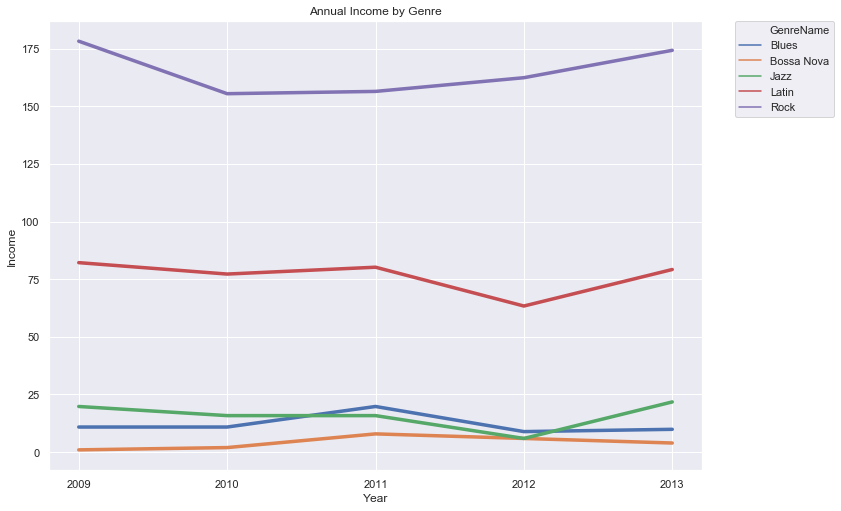

In [88]:
fig, _ = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.lineplot(x='Year', y='Income', hue='GenreName', data=df3)
plt.title("Annual Income by Genre")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for l in ax.lines:
    plt.setp(l, linewidth=3.5)

### Query \#4: Lets see how monthly income varies in 2013 for Rock genre

In [97]:
q4 = '''
SELECT
    STRFTIME('%Y', i.InvoiceDate) Year, 
	STRFTIME('%m', i.InvoiceDate) Month,
	SUM(il.Quantity * il.UnitPrice) Income,
	g.Name GenreName
FROM Invoice i
    JOIN InvoiceLine il
    ON i.InvoiceId = il.InvoiceId
    JOIN Track t
    ON t.TrackId = il.TrackId
    JOIN Genre g
    ON t.GenreId = g.GenreId
WHERE GenreName = 'Rock' AND Year = '2013'
GROUP BY 1,2;
'''

In [98]:
df4 = pd.read_sql(q4, engine)
df4

,Year,Month,Income,GenreName
0,2013,01,6.93,Rock
1,2013,02,16.83,Rock
2,2013,03,5.94,Rock
3,2013,04,9.90,Rock
4,2013,05,10.89,Rock
5,2013,06,21.78,Rock
6,2013,07,7.92,Rock
7,2013,08,16.83,Rock
8,2013,09,22.77,Rock
9,2013,10,17.82,Rock


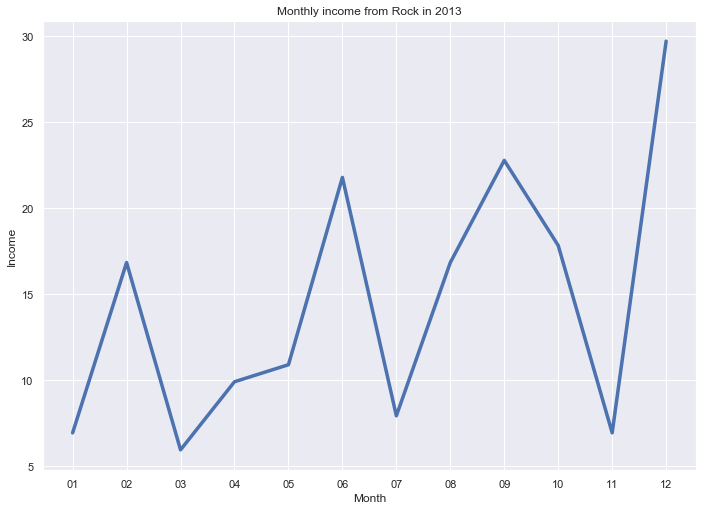

In [100]:
fig, _ = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.lineplot(x='Month', y='Income', data=df4)
plt.title("Monthly income from Rock in 2013")
for l in ax.lines:
    plt.setp(l, linewidth=3.5)